### Анализ

In [77]:
import pandas as pd
import os

# Load the dataset
file_path = 'data.csv'
file_path_optimize = "optimize_data.csv"
df = pd.read_csv(file_path)

In [78]:
# Анализ набор данных
# a. Размер файла на диске
file_size_on_disk = os.path.getsize(file_path)
print(f"Размер файла на диске: {file_size_on_disk} байты")

# b. Использование памяти набора данных при загрузке в память
memory_usage = df.memory_usage(deep=True, index=False)
print(f"Использование памяти набора данных в памяти: {memory_usage.sum()} байты")

memory_usage_start_dict = memory_usage.to_dict()
memory_usage_start_dict = {
    k: v for k, v in sorted(memory_usage_start_dict.items(), key=lambda item: -item[1])
}

data = []
column_types_dict = df.dtypes.to_dict()
for k, v in memory_usage_start_dict.items():
    print(
        f"{k:<20}    {v:<15}    {int(100.0*float(v)/memory_usage.sum()):<15}    {column_types_dict[k]}"
    )
    data.append(
        {
            "name": k,
            "type": str(column_types_dict[k]),
            "memory": v,
        }
    )

pd.DataFrame.from_dict(data).to_json(
    "before_optimize_statistics.json", indent=1, force_ascii=False, orient="records"
)

Размер файла на диске: 1257052019 байты
Использование памяти набора данных в памяти: 1747633362 байты
photos_links            615913989          35                 object
descr                   350690986          20                 object
complectation           232737158          13                 object
catalog_link            46634533           2                  object
url                     37550176           2                  object
orig_url                37550176           2                  object
state                   33931412           1                  object
transmission            30430270           1                  object
date_posted             29187990           1                  object
body_type               28885566           1                  object
customs                 28639968           1                  object
pts                     27277382           1                  object
drive                   26777822           1                  object
c

### Оптимизация

In [79]:
from sklearn.preprocessing import LabelEncoder

# Преобразовать все колонки с типом данных «object» в категориальные, если количество уникальных значений колонки составляет менее 50%
for col in df.select_dtypes(include="object").columns:
    label_encoder = LabelEncoder()
    if df[col].nunique() / len(df) < 0.5:
        df[col] = label_encoder.fit_transform(df[col])

# Понижающее преобразование типов «int» колонок
for col in df.select_dtypes(include="int").columns:
    df[col] = pd.to_numeric(df[col], downcast="integer")

# Понижающее преобразование типов «float» колонок
for col in df.select_dtypes(include="float").columns:
    df[col] = pd.to_numeric(df[col], downcast="float")


In [80]:
memory_usage = df.memory_usage(deep=True, index=False)
print(f"Использование памяти набора данных в памяти: {memory_usage.sum()} байты")

memory_usage_start_dict = memory_usage.to_dict()
memory_usage_start_dict = {
    k: v for k, v in sorted(memory_usage_start_dict.items(), key=lambda item: -item[1])
}

data = []
column_types_dict = df.dtypes.to_dict()
for k, v in memory_usage_start_dict.items():
    print(
        f"{k:<20}    {v:<15}    {int(100.0*float(v)/memory_usage.sum()):<15}    {column_types_dict[k]}"
    )
    data.append(
        {
            "name": k,
            "type": str(column_types_dict[k]),
            "memory": v,
        }
    )

pd.DataFrame.from_dict(data).to_json(
    "after_optimize_statistics.json", indent=1, force_ascii=False, orient="records"
)

df.to_csv(file_path_optimize)

Использование памяти набора данных в памяти: 1064992647 байты
photos_links            615913989          57                 object
descr                   350690986          32                 object
url                     37550176           3                  object
orig_url                37550176           3                  object
offer_id                2661408            0                  float64
views_total             1330704            0                  float32
views_today             1330704            0                  float32
year                    1330704            0                  float32
mileage                 1330704            0                  float32
engine_volume           1330704            0                  float32
engine_power            1330704            0                  float32
owners_count            1330704            0                  float32
complectation           1330704            0                  int32
price                   1330704   

### Подготовка данных

In [81]:
# Выбираем 10 произвольных колонок
selected_columns = [
    "brand",
    "model",
    "generation",
    "views_total",
    "views_today",
    "fuel_type",
    "year",
    "mileage",
    "price",
]


# Читаем файл по частям и сохраняем только нужные данные
chunk_size = 10000
chunks = pd.read_csv(
    file_path_optimize, usecols=selected_columns, chunksize=chunk_size
)

# Объединяем все чанки в один DataFrame
subset_df = pd.concat(chunks)

# Сохраняем полученный поднабор в отдельный файл
subset_df.to_csv("subset_data.csv", index=False)

### Построение графиков

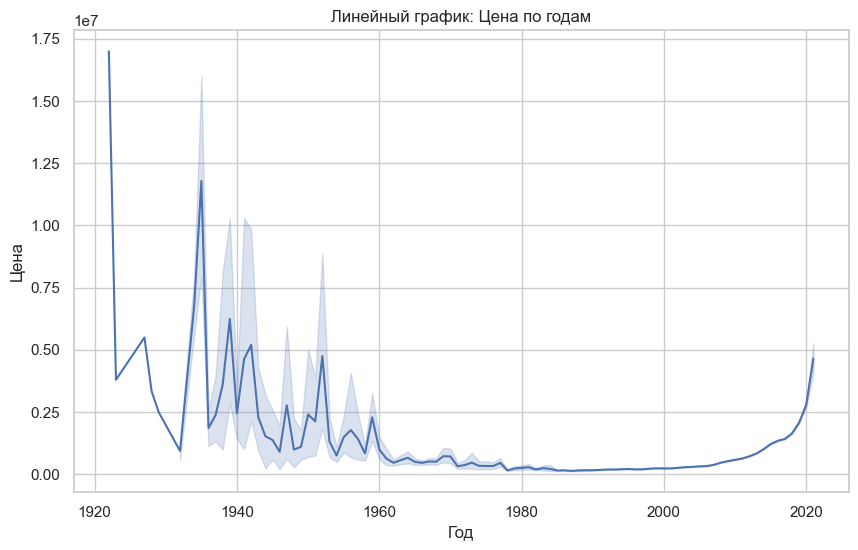

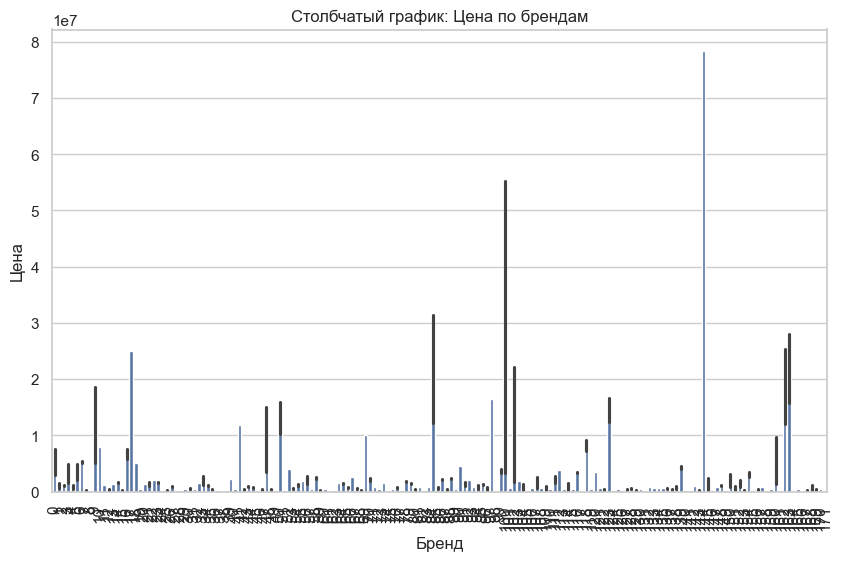

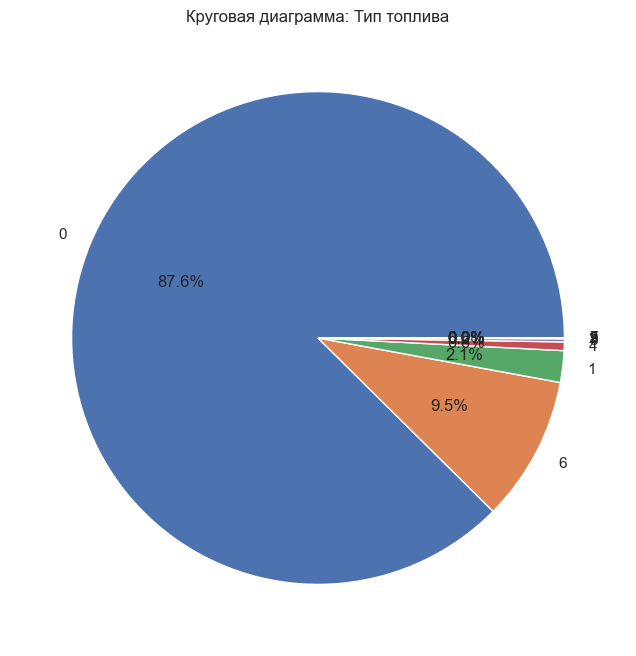

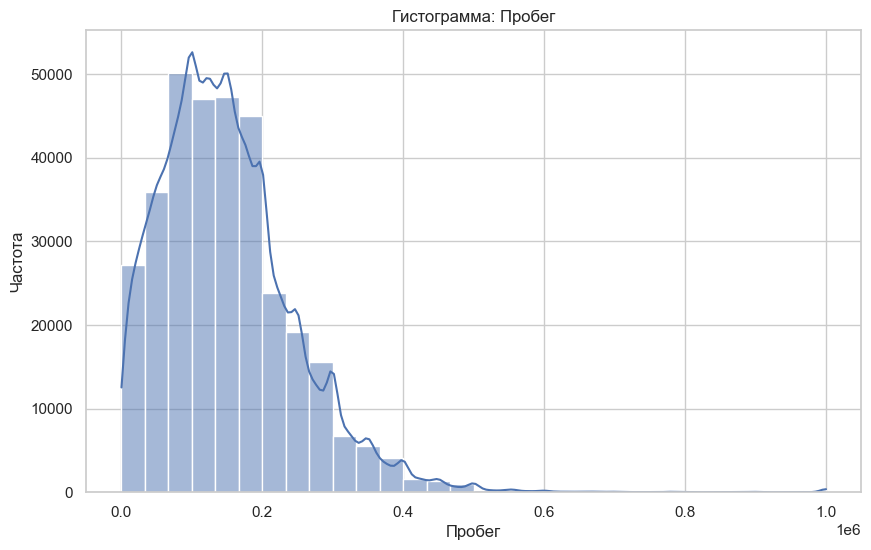

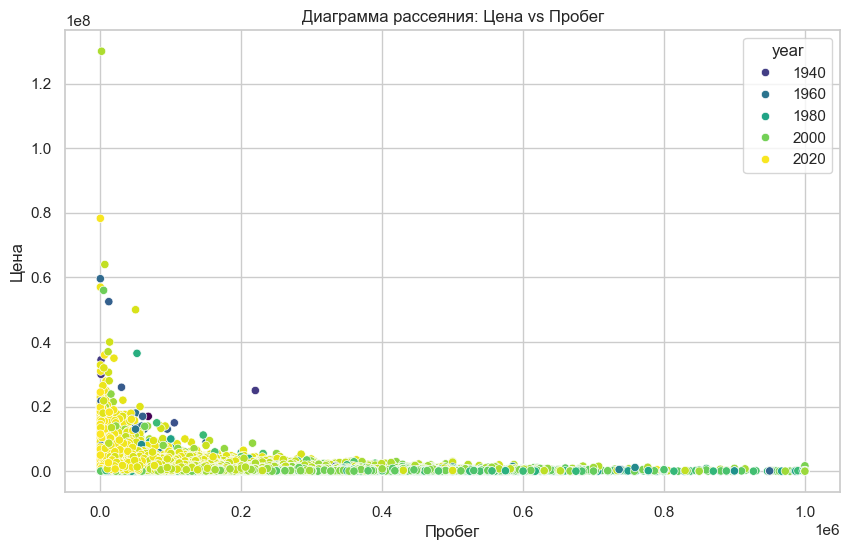

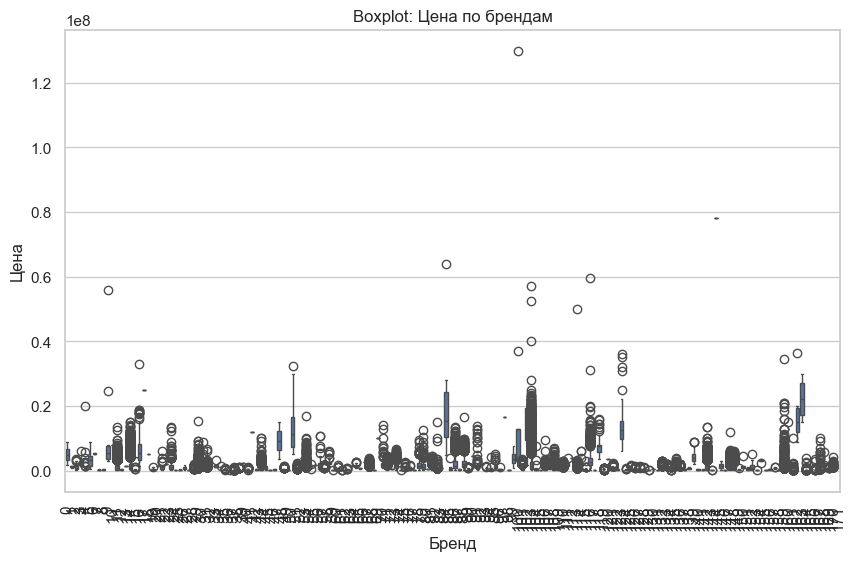

In [82]:
import seaborn as sns

import matplotlib.pyplot as plt

# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

# Линейный график
plt.figure(figsize=(10, 6))
sns.lineplot(data=subset_df, x='year', y='price')
plt.title('Линейный график: Цена по годам')
plt.xlabel('Год')
plt.ylabel('Цена')
plt.show()

# Столбчатый график
plt.figure(figsize=(10, 6))
sns.barplot(data=subset_df, x='brand', y='price')
plt.title('Столбчатый график: Цена по брендам')
plt.xlabel('Бренд')
plt.ylabel('Цена')
plt.xticks(rotation=90)
plt.show()

# Круговая диаграмма
plt.figure(figsize=(8, 8))
subset_df['fuel_type'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Круговая диаграмма: Тип топлива')
plt.ylabel('')
plt.show()

# Гистограмма
plt.figure(figsize=(10, 6))
sns.histplot(subset_df['mileage'], bins=30, kde=True)
plt.title('Гистограмма: Пробег')
plt.xlabel('Пробег')
plt.ylabel('Частота')
plt.show()

# Диаграмма рассеяния
plt.figure(figsize=(10, 6))
sns.scatterplot(data=subset_df, x='mileage', y='price', hue='year', palette='viridis')
plt.title('Диаграмма рассеяния: Цена vs Пробег')
plt.xlabel('Пробег')
plt.ylabel('Цена')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=subset_df, x='brand', y='price')
plt.title('Boxplot: Цена по брендам')
plt.xlabel('Бренд')
plt.ylabel('Цена')
plt.xticks(rotation=90)
plt.show()